#**Maestría en Inteligencia Artificial Aplicada**
## TC5035.10
##**Curso: Proyecto Integrador**
###Tecnológico de Monterrey

---

**Docente Titular**: Dra. Grettel Barceló Alonso y Dr. Luis Eduardo Falcón

**Docente Asistente**: Veronica Guzman del Valle

**Docente Tutor**: Eduviges Ludivina Facundo Flores

**Docente del ITCJ Responsable**: Mtra. Yadira Dozal Assmar

#**Nombre del Proyecto:**
---
*"Modelado de serie de tiempo para pronosticar la demanda de prórrogas de licenciatura en ITCJ"*

---

#**Integrantes Equipo #13:**
* A01796362 Eduardo Perez Carrillo
* A01795907 Nancy Teresa Zapien García
* A01796060 Hugo Alberto Cuevas García

In [ ]:
# =========================
# LIBRERÍAS BASE
# =========================
import pandas as pd              # Manipulación y análisis de datos (DataFrames)
import numpy as np               # Operaciones numéricas (vectores, arrays, etc.)
import matplotlib.pyplot as plt  # Visualización (gráficas)
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

# Define la ruta completa al archivo
ruta_archivo = "/content/drive/MyDrive/Master/Proyecto Integrador/Semana5/dataset.csv"

# Lee el archivo directamente
df = pd.read_csv(ruta_archivo, encoding="latin1")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =========================
# 2) VALIDACIÓN RÁPIDA DE CARGA
# =========================
print("---------------------------")
# Shape: (filas, columnas). Sirve para verificar que coincida con el tamaño esperado del dataset.
print("Shape:", df.shape)

print("---------------------------")
# Vista rápida de las primeras filas: ayuda a confirmar estructura, valores y nombres de columnas.
display(df.head())

print("---------------------------")
# Tipos de datos detectados por pandas. Aquí es normal ver:
# - 'object' para texto y fechas cuando vienen como strings.
# Más adelante convertiremos las fechas a datetime.
print(df.dtypes)


---------------------------
Shape: (1765, 6)
---------------------------


,aprobado,carrera,periodo_solicitud,periodo_inicio,num_semestres_aprobados,semestre_actual
0,si,Licenciatura AdministraciÃ³n,01/07/2019,01/01/2020,7,11
1,si,IngenierÃ­a Industria EAD,01/07/2019,01/01/2020,4,12
2,si,IngenierÃ­a Industrial,01/07/2019,01/01/2020,13,6
3,si,Licenciatura AdministraciÃ³n,01/07/2019,01/01/2020,11,7
4,si,Licenciatura AdministraciÃ³n,01/07/2019,01/01/2020,8,8


---------------------------
aprobado                   object
carrera                    object
periodo_solicitud          object
periodo_inicio             object
num_semestres_aprobados     int64
semestre_actual             int64
dtype: object


## **ANÁLISIS DE DATOS FALTANTES (EDA)**

En este bloque se revisa la calidad del dataset,
identificando valores faltantes (NaN) por columna.

Este paso es fundamental antes de cualquier transformación o modelado, ya que valores faltantes pueden sesgar resultados.

In [ ]:
missing_summary = (
    df.isna()
      .sum()
      .to_frame(name="n_missing")
      .assign(pct_missing=lambda x: 100 * x["n_missing"] / len(df))
)

display(missing_summary)

,n_missing,pct_missing
aprobado,0,0.0
carrera,0,0.0
periodo_solicitud,0,0.0
periodo_inicio,0,0.0
num_semestres_aprobados,0,0.0
semestre_actual,0,0.0


Se revisa la presencia de valores faltantes en las columnas críticas del análisis. Este paso se realiza después de normalizar los nombres de las columnas.

In [ ]:
print("Columnas disponibles en el dataset:")
print(df.columns.tolist())

# Columnas críticas esperadas
expected_critical_cols = [
    "aprobado",
    "carrera",
    "periodo_solicitud",
    "periodo_inicio",
    "num_semestres_aprobados",
    "semestre_actual"
]

# Mantener solo las columnas que realmente existen
critical_cols = [c for c in expected_critical_cols if c in df.columns]

print("\nColumnas críticas encontradas:")
print(critical_cols)

# Revisión de valores nulos
missing_critical = (
    df[critical_cols]
    .isna()
    .sum()
    .to_frame(name="n_missing")
)

display(missing_critical)

Columnas disponibles en el dataset:
['aprobado', 'carrera', 'periodo_solicitud', 'periodo_inicio', 'num_semestres_aprobados', 'semestre_actual']

Columnas críticas encontradas:
['aprobado', 'carrera', 'periodo_solicitud', 'periodo_inicio', 'num_semestres_aprobados', 'semestre_actual']


,n_missing
aprobado,0
carrera,0
periodo_solicitud,0
periodo_inicio,0
num_semestres_aprobados,0
semestre_actual,0


In [ ]:
# Revisión de strings vacíos o solo espacios
empty_strings = (
    df[critical_cols]
    .astype(str)
    .apply(lambda col: col.str.strip().eq("").sum())
)

empty_strings


,0
aprobado,0
carrera,0
periodo_solicitud,0
periodo_inicio,0
num_semestres_aprobados,0
semestre_actual,0



## **NORMALIZACIÓN DE NOMBRES DE COLUMNAS**


Estandarizamos los nombres de las columnas:
 - strip(): elimina espacios en blanco al inicio y final
 - lower(): convierte todo a minúsculas

Esto es una buena práctica porque:
 1) Evita errores por diferencias de mayúsculas/minúsculas.
 2) Facilita la escritura de código reproducible.
 3) Permite mantener consistencia en todo el pipeline.

In [ ]:
df.columns = [c.strip().lower() for c in df.columns]

# Imprimimos la lista de columnas para verificar el resultado
print(df.columns.tolist())


['aprobado', 'carrera', 'periodo_solicitud', 'periodo_inicio', 'num_semestres_aprobados', 'semestre_actual']



## **NORMALIZACIÓN DE LA VARIABLE OBJETIVO (APROBADO)**

El objetivo es convertir la variable categórica "aprobado"

en una variable binaria numérica:

   1 -> solicitud aprobada
   
   0 -> solicitud no aprobada

Esto es necesario porque:
 - Los modelos de machine learning y series temporales
   trabajan con variables numéricas.
 - Facilita conteos, agregaciones y métricas.
 - Evita ambigüedades por diferentes formas de escritura.

In [ ]:
df["aprobado_norm"] = (
    df["aprobado"]
    # Convertimos a string para evitar problemas si hay valores nulos o mixtos
    .astype(str)
    # Eliminamos espacios en blanco
    .str.strip()
    # Convertimos a minúsculas para estandarizar
    .str.lower()
    # Normalizamos variaciones comunes del "sí"
    .replace({"sí": "si"})
    # Mapeo final a binario:
    # valores considerados como aprobación -> 1
    # cualquier otro valor -> 0
    .map(lambda x: 1 if x in ["si", "1", "true", "aprobado", "yes", "y"] else 0)
)

# =========================
# VERIFICACIÓN DE RESULTADOS
# =========================
# Distribución original de la variable categórica
print("Valores originales:")
print(df["aprobado"].value_counts())

# Distribución de la variable binaria normalizada
print("\nValores normalizados:")
print(df["aprobado_norm"].value_counts())


Valores originales:
aprobado
Si    1136
si     484
No     112
no      33
Name: count, dtype: int64

Valores normalizados:
aprobado_norm
1    1620
0     145
Name: count, dtype: int64



## **EXPLORACIÓN DE LA VARIABLE "CARRERA"**

En esta etapa realizamos una exploración básica de la variable categórica "carrera"

 con el objetivo de:
  1) Conocer cuántas carreras distintas existen en el dataset.
 2) Identificar las carreras con mayor número de solicitudes.
 3) Detectar posibles categorías dominantes o poco representadas.


In [ ]:
# Número total de carreras únicas
print("Número de carreras únicas:", df["carrera"].nunique())

# Frecuencia de solicitudes por carrera
# Se muestran solo las 15 carreras con mayor número de registros
df["carrera"].value_counts().head(15)

Número de carreras únicas: 15


,count
carrera,
IngenierÃ­a Industrial,325
Licenciatura AdministraciÃ³n,321
Contador PÃºblico,207
IngenierÃ­a MecatrÃ³nica,181
IngenierÃ­a LogÃ­stica,173
IngenierÃ­a GestiÃ³n Empresarial,161
IngenierÃ­a Sistemas Computacionales,139
IngenierÃ­a Electromecanica,87
IngenierÃ­a MecÃ¡nica,42



## **NORMALIZACIÓN Y AGRUPACIÓN DE LA VARIABLE "CARRERA"**

En este paso se crea una versión normalizada de la variable "carrera" con el objetivo de reducir la cardinalidad de categorías y facilitar el análisis agregado.

Específicamente, todas las carreras que pertenecen a la modalidad de Educación a Distancia (EAD) se agrupan en una sola categoría: "EAD".


In [ ]:
# Crear una copia normalizada de la carrera:
# - astype(str): asegura compatibilidad aunque existan valores nulos
# - strip(): elimina espacios en blanco al inicio y final
df["carrera_norm"] = df["carrera"].astype(str).str.strip()

# Agrupar todas las carreras cuya descripción termina en "EAD"
# - str.upper(): evita problemas por mayúsculas/minúsculas
# - str.endswith("EAD"): identifica la modalidad EAD
#
# Todas estas observaciones se asignan a la categoría única "EAD"
df.loc[
    df["carrera_norm"].str.upper().str.endswith("EAD"),
    "carrera_norm"
] = "EAD"

# =========================
# VERIFICACIÓN DE RESULTADOS
# =========================
# Distribución original de carreras (top 15)
print("Carreras originales (top 15):")
print(df["carrera"].value_counts().head(15))

# Distribución después de la normalización (top 15)
print("\nCarreras normalizadas (top 15):")
print(df["carrera_norm"].value_counts().head(15))



Carreras originales (top 15):
carrera
IngenierÃ­a Industrial                                          325
Licenciatura AdministraciÃ³n                                    321
Contador PÃºblico                                               207
IngenierÃ­a MecatrÃ³nica                                        181
IngenierÃ­a LogÃ­stica                                          173
IngenierÃ­a GestiÃ³n Empresarial                                161
IngenierÃ­a Sistemas Computacionales                            139
IngenierÃ­a Electromecanica                                      87
IngenierÃ­a MecÃ¡nica                                            42
IngenierÃ­a ElÃ©ctrica                                           38
IngenierÃ­a Industria EAD                                        33
IngenierÃ­a ElectrÃ³nica                                         25
IngenierÃ­a TecnologÃ­as de la InformaciÃ³n y Comunicaciones     22
IngenierÃ­a GestiÃ³n Empresarial EAD                             10
IngenierÃ­

In [ ]:
def parse_and_fix_semester_dates(s: pd.Series) -> pd.Series:
    """
    Convierte una serie de fechas a formato datetime mensual real.

    La función:
    - Maneja ambigüedad entre formatos dd/mm/yyyy y mm/dd/yyyy.
    - Identifica automáticamente el parseo más coherente.
    - PRESERVA el mes original para permitir análisis de mayor granularidad (mensual).

    Parámetros
    ----------
    s : pd.Series
        Serie de fechas en formato texto.

    Retorna
    -------
    pd.Series
        Serie de fechas normalizadas a formato datetime (Primer día de cada mes).
    """

    # =========================
    # 1) PARSEO DE FECHAS CON AMBIGÜEDAD
    # =========================
    # Intento 1: interpretar la fecha como día/mes/año (formato común en LATAM)
    dt1 = pd.to_datetime(s, errors="coerce", dayfirst=True)

    # Intento 2: interpretar la fecha como mes/día/año (formato común en sistemas anglosajones)
    dt2 = pd.to_datetime(s, errors="coerce", dayfirst=False)

    # =========================
    # 2) SELECCIÓN DEL PARSEO MÁS COHERENTE
    # =========================
    # Extraemos los meses resultantes de cada intento
    m1 = dt1.dt.month
    m2 = dt2.dt.month

    # Regla de decisión optimizada:
    # Si m1 resulta en valores nulos o inconsistentes y m2 funciona, usamos m2.
    # En este caso, mantenemos la lógica de que si m2 cae en meses clave (1 o 7)
    # y m1 no, priorizamos m2, pero sin descartar otros meses.
    use_dt2 = (dt1.isna() & dt2.notna()) | ((~m1.isin([1, 7])) & (m2.isin([1, 7])))

    # Inicialmente usamos el primer parseo
    dt = dt1.copy()

    # Sustituimos por el segundo parseo donde sea más consistente
    dt[use_dt2] = dt2[use_dt2]

    # =========================
    # 3) NORMALIZACIÓN MENSUAL (NO SEMESTRAL)
    # =========================
    # En lugar de forzar a Enero/Julio, normalizamos al primer día del mes
    # detectado. Esto permite tener hasta 12 registros por año.

    dt_monthly = pd.to_datetime(
        dict(year=dt.dt.year, month=dt.dt.month, day=1),
        errors="coerce"
    )

    return dt_monthly


## **PARSEO Y NORMALIZACIÓN DE FECHAS A FORMATO SEMESTRAL**

 Aplicamos la función parse_and_fix_semester_dates() a las dos columnas temporales clave:
 - periodo_solicitud: semestre en el que el alumno realizó formalmente la solicitud.
 - periodo_inicio: semestre en el que el alumno desea comenzar a utilizar la prórroga.

 Ambas se convierten a datetime y se colapsan a una fecha representativa semestral:
 - 01/01/YYYY  ->  YYYY-S1
 - 01/07/YYYY  ->  YYYY-S2

In [ ]:
# Esto estandariza el eje temporal para agregaciones y modelado de series.

df["periodo_solicitud_dt"] = parse_and_fix_semester_dates(df["periodo_solicitud"])
df["periodo_inicio_dt"] = parse_and_fix_semester_dates(df["periodo_inicio"])

# =========================
# CONTROL DE CALIDAD: VALORES NULOS
# =========================
# Verificamos cuántas fechas no pudieron ser parseadas (NaT).
# Un número alto aquí indicaría:
# - formatos inválidos,
# - valores faltantes,
# - errores de captura,
# - o inconsistencias que requieren limpieza adicional.
print("Nulos en periodo_solicitud_dt:", df["periodo_solicitud_dt"].isna().sum())
print("Nulos en periodo_inicio_dt:", df["periodo_inicio_dt"].isna().sum())



Nulos en periodo_solicitud_dt: 0
Nulos en periodo_inicio_dt: 0



## **VALIDACIÓN DE CONSISTENCIA SEMESTRAL**

En este paso verificamos explícitamente que las fechas normalizadas
 cumplen con el esquema semestral definido:
   - Enero (mes = 1)  -> Primer semestre (S1)
   - Julio  (mes = 7) -> Segundo semestre (S2)

 No deberían aparecer otros meses (2–6, 8–12).
 Si aparecen, indicaría un error en el parseo o en los datos originales.


In [ ]:
print(
    "Meses únicos en periodo_solicitud_dt:",
    sorted(df["periodo_solicitud_dt"].dt.month.unique())
)

print(
    "Meses únicos en periodo_inicio_dt:",
    sorted(df["periodo_inicio_dt"].dt.month.unique())
)

Meses únicos en periodo_solicitud_dt: [np.int32(1), np.int32(7)]
Meses únicos en periodo_inicio_dt: [np.int32(1), np.int32(7)]



## **CREACIÓN DE ETIQUETAS SEMESTRALES (YYYY-S1 / YYYY-S2)**

En este paso construimos etiquetas de semestre en formato:
   "AÑO-S1" para enero (1)
   "AÑO-S2" para julio (7)

Estas etiquetas son útiles para:
 - visualización y análisis exploratorio (EDA)
 - reportes y tablas (más legible que un datetime)
 - validación rápida del alineamiento temporal

Importante: para modelado, seguimos usando datetime/índices numéricos, pero esta columna mejora la interpretabilidad.

In [ ]:
def semestre_label(dt):
    """
    Convierte una serie datetime semestral (enero/julio) a una etiqueta tipo 'YYYY-S1' o 'YYYY-S2'.

    Parámetros
    ----------
    dt : pd.Series (datetime64)
        Serie de fechas ya normalizadas a meses 1 (enero) o 7 (julio).

    Retorna
    -------
    pd.Series
        Etiquetas en texto: 'YYYY-S1' / 'YYYY-S2'.
    """
    # Mapear el mes a semestre:
    # - 1 -> S1
    # - 7 -> S2
    semestre = dt.dt.month.map({1: "S1", 7: "S2"})

    # Concatenar año + '-' + semestre
    return dt.dt.year.astype(str) + "-" + semestre


# Crear etiquetas para:
# - Semestre en el que se solicitó formalmente la prórroga
df["semestre_solicitud"] = semestre_label(df["periodo_solicitud_dt"])

# - Semestre en el que se planea utilizar la prórroga
df["semestre_inicio"] = semestre_label(df["periodo_inicio_dt"])


# =========================
# VERIFICACIÓN VISUAL (SANITY CHECK)
# =========================
# Mostramos un subconjunto de columnas para confirmar:
# 1) que las fechas se parsearon correctamente,
# 2) que la etiqueta coincide con el semestre real (enero/julio),
# 3) que no hay desalineaciones evidentes entre texto original y datetime.
df[[
    "periodo_solicitud", "periodo_solicitud_dt", "semestre_solicitud",
    "periodo_inicio", "periodo_inicio_dt", "semestre_inicio"
]].head(10)


,periodo_solicitud,periodo_solicitud_dt,semestre_solicitud,periodo_inicio,periodo_inicio_dt,semestre_inicio
0,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
1,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
2,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
3,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
4,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
5,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
6,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
7,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
8,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1
9,01/07/2019,2019-07-01,2019-S2,01/01/2020,2020-01-01,2020-S1



## **ORDENAMIENTO TEMPORAL POR SEMESTRE DE SOLICITUD**

Para cualquier análisis de series temporales es indispensable que los datos estén correctamente ordenados en el tiempo.

Aquí ordenamos el dataset usando la fecha datetime semestral asociada al periodo de solicitud de la prórroga.

In [ ]:

df = (
    df
    .sort_values("periodo_solicitud_dt")  # orden cronológico
    .reset_index(drop=True)               # reinicio de índice para coherencia
)

# =========================
# VERIFICACIÓN DEL RANGO TEMPORAL
# =========================
# Confirmamos explícitamente cuál es:
# - el primer semestre presente en el dataset
# - el último semestre presente en el dataset
#
# Esta información será clave más adelante para:
# - definir puntos de corte (cutoff) configurables,
# - validar horizontes de pronóstico,
# - justificar el rango temporal analizado.

print("Primer semestre:", df["semestre_solicitud"].iloc[0])
print("Último semestre:", df["semestre_solicitud"].iloc[-1])


Primer semestre: 2019-S2
Último semestre: 2025-S2


In [ ]:
# =========================
# PARÁMETRO CONFIGURABLE
# =========================
ULTIMO_SEMESTRE = "2025-S2"   # <-- cambia aquí cuando lo necesites



## **CONVERSIÓN DE SEMESTRE A ÍNDICE TEMPORAL NUMÉRICO**

En series temporales es común trabajar con un índice numérico ordenable
(0, 1, 2, 3, ...) en lugar de etiquetas textuales.

 Aquí convertimos etiquetas del tipo:

   "YYYY-S1"
   "YYYY-S2"

 a un índice entero continuo que respeta el orden temporal.

La regla utilizada es:
  índice = (año * 2) + offset

 donde:
   offset = 0  -> primer semestre (S1)
   offset = 1  -> segundo semestre (S2)

 Ejemplos:
   2023-S1 -> 2023*2 + 0 = 4046
   2023-S2 -> 2023*2 + 1 = 4047
   2024-S1 -> 2024*2 + 0 = 4048

 Este índice:
 - preserva el orden cronológico,
 - permite comparar semestres con operadores numéricos (<, >, <=),
 - facilita la creación de puntos de corte (cutoff),
 - es ideal para validación walk-forward.


In [ ]:

def semestre_index(label):
    """
    Convierte una etiqueta semestral 'YYYY-S1' / 'YYYY-S2'
    en un índice temporal entero ordenable.

    Parámetros
    ----------
    label : str
        Etiqueta semestral en formato 'YYYY-S1' o 'YYYY-S2'.

    Retorna
    -------
    int
        Índice temporal numérico que preserva el orden cronológico.
    """
    # Separar la etiqueta en año y semestre
    year, sem = label.split("-")

    # Asignar offset según semestre:
    # S1 -> 0
    # S2 -> 1
    offset = 0 if sem == "S1" else 1

    # Construir el índice final
    return int(year) * 2 + offset


# =========================
# APLICACIÓN DEL ÍNDICE AL DATASET
# =========================
# Creamos una nueva columna con el índice semestral numérico
# que será usada para:
# - filtrar rangos temporales,
# - definir el último semestre considerado (cutoff),
# - validar el orden temporal del dataset.
df["semestre_idx"] = df["semestre_solicitud"].apply(semestre_index)


# =========================
# DEFINICIÓN DEL PUNTO DE CORTE (CUTOFF)
# =========================
# Convertimos el último semestre permitido (configurable)
# al mismo índice numérico para poder compararlo directamente.
#
# Ejemplo:
#   ULTIMO_SEMESTRE = "2025-S2"
#   cutoff_idx = 2025*2 + 1 = 4051
cutoff_idx = semestre_index(ULTIMO_SEMESTRE)

print("Cutoff index:", cutoff_idx)


Cutoff index: 4051



## **APLICACIÓN DEL CUTOFF TEMPORAL (FILTRADO DEL DATASET)**

En este paso se construye el dataset que será utilizado para:
 - análisis exploratorio (EDA),
 - agregaciones temporales,
 - entrenamiento de modelos,
 - validación walk-forward.

Para ello, se aplica un punto de corte temporal (cutoff_idx) que define el último semestre permitido en el análisis.

 Cualquier observación con semestre_idx > cutoff_idx se excluye, garantizando que NO se utilice información futura (data leakage).

In [ ]:
df_eda = (
    df[df["semestre_idx"] <= cutoff_idx]
    .copy()   # Se crea una copia explícita para evitar SettingWithCopyWarning
)

# =========================
# VERIFICACIÓN DEL RANGO TEMPORAL INCLUIDO
# =========================
# Mostramos explícitamente qué semestres quedaron dentro del rango analizado.
# Esta salida sirve para:
# - confirmar que el cutoff se aplicó correctamente,
# - documentar el periodo histórico utilizado,
# - detectar exclusiones inesperadas.
print("Semestres incluidos:")
print(sorted(df_eda["semestre_solicitud"].unique()))


Semestres incluidos:
['2019-S2', '2020-S2', '2021-S1', '2021-S2', '2022-S1', '2022-S2', '2023-S1', '2023-S2', '2024-S1', '2024-S2', '2025-S1', '2025-S2']


In [ ]:
# CÓDIGO MODIFICADO PARA MÁS DATOS
agg = (
    df_eda
    .groupby(pd.Grouper(key='periodo_solicitud_dt', freq='MS')) # 'MS' = Month Start (Mensual)
    .agg(
        total_solicitudes=("aprobado_norm", "size"),
        aprobadas=("aprobado_norm", "sum"),
        promedio_semestre_alumno=("semestre_actual", "mean"),
        promedio_duracion_prorroga=("num_semestres_aprobados", "mean"),
        total_semestres_otorgados=("num_semestres_aprobados", "sum")
    )
)

# Muy importante: Como ahora es mensual, habrá meses vacíos.
# Debemos llenar los NaNs de las métricas con 0 para que el modelo no falle.
agg["total_solicitudes"] = agg["total_solicitudes"].fillna(0)
agg['tasa_aprobacion'] = agg['aprobadas'] / agg['total_solicitudes']
# Llenar NaNs donde total_solicitudes fue 0
agg['tasa_aprobacion'] = agg['tasa_aprobacion'].fillna(0)
agg["aprobadas"] = agg["aprobadas"].fillna(0)
# Para los promedios, podemos llenar con la media global para no sesgar
agg["promedio_semestre_alumno"] = agg["promedio_semestre_alumno"].fillna(agg["promedio_semestre_alumno"].mean())
agg["promedio_duracion_prorroga"] = agg["promedio_duracion_prorroga"].fillna(agg["promedio_duracion_prorroga"].mean())

## **MIN MAX**
Se aplicó la técnica de normalización Min-Max para transformar las variables numéricas a un rango común de [0, 1]. Esta decisión es crítica debido a la disparidad de magnitudes entre las variables (ej. el 'total de solicitudes' posee valores significativamente mayores que el 'promedio de semestre'). El escalamiento previene que el modelo de aprendizaje automático o algoritmos como PCA asignen una importancia artificialmente alta a las variables con escalas mayores, asegurando una convergencia más rápida y una interpretación equitativa de todas las características."

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 1. Seleccionamos las columnas numéricas que deseamos escalar
# Es recomendable escalar todas las métricas que entrarán al modelo o al PCA
agg['no_aprobadas'] = agg['total_solicitudes'] - agg['aprobadas']

columnas_a_escalar = [
    'total_solicitudes',
    'aprobadas',
    'no_aprobadas',
    'promedio_semestre_alumno',
    'promedio_duracion_prorroga',
    'total_semestres_otorgados'
]

# 2. Inicializamos el escalador Min-Max (rango por defecto 0 a 1)
scaler = MinMaxScaler()

# 3. Aplicamos el escalamiento
# Creamos nuevas columnas con el sufijo '_scaled' para mantener los datos originales
agg_scaled = agg.copy()

agg_scaled[columnas_a_escalar] = scaler.fit_transform(agg[columnas_a_escalar])

# 4. Visualizamos el resultado
print("Datos escalados (Rango 0-1):")
display(agg_scaled.head())

Datos escalados (Rango 0-1):


,total_solicitudes,aprobadas,promedio_semestre_alumno,promedio_duracion_prorroga,total_semestres_otorgados,tasa_aprobacion,no_aprobadas
periodo_solicitud_dt,,,,,,,
2019-07-01,0.151163,0.152941,0.583778,1.000000,0.15867,1.0,0.0
2019-08-01,0.000000,0.000000,0.591308,0.559455,0.00000,0.0,0.0
2019-09-01,0.000000,0.000000,0.591308,0.559455,0.00000,0.0,0.0
2019-10-01,0.000000,0.000000,0.591308,0.559455,0.00000,0.0,0.0
2019-11-01,0.000000,0.000000,0.591308,0.559455,0.00000,0.0,0.0


In [ ]:
# Extraemos el semestre (S1 / S2)
agg["semestre"] = agg.index.month.map({1: "S1", 7: "S2"})

# Definimos todas las métricas que queremos comparar
metricas_comparar = [
    "total_solicitudes",
    "aprobadas",
    "tasa_aprobacion",
    "promedio_semestre_alumno",
    "promedio_duracion_prorroga"
]

# Calculamos el promedio semestral para identificar estacionalidad
estacionalidad_stats = agg.groupby("semestre")[metricas_comparar].mean()

display(estacionalidad_stats)

,total_solicitudes,aprobadas,tasa_aprobacion,promedio_semestre_alumno,promedio_duracion_prorroga
semestre,,,,,
S1,111.166667,98.666667,0.681177,6.449392,5.680881
S2,156.857143,146.857143,0.917862,6.579076,6.537548



## **ANÁLISIS DE DEMANDA POR MODALIDAD (EAD vs NO EAD)**

* La segmentación de los datos entre Educación a Distancia (EAD) y Modalidad Presencial (No EAD) mediante agregaciones avanzadas es una decisión estratégica fundamentada en:

* Detección de Sesgos en el Perfil del Alumno (semestre_promedio): Esta métrica permite identificar si los alumnos de una modalidad solicitan prórrogas en etapas más tempranas o tardías de su carrera. Justificación para ML: Si el promedio de semestre difiere significativamente entre EAD y Presencial, la "Modalidad" se convierte en una característica de alta varianza que el modelo debe utilizar para ajustar sus predicciones de demanda.

* Análisis de Equidad Institucional (tasa_aprobacion): Comparar la tasa de aprobación entre modalidades permite diagnosticar si el proceso de selección es uniforme. Si una modalidad tiene una tasa sistemáticamente menor, el modelo de pronóstico necesitará una variable de "Modo" para entender por qué, a pesar de tener mucha demanda, el número de alumnos finales es bajo.

* Evaluación de la Carga de Beneficio (duracion_promedio): Al medir cuántos semestres de prórroga se otorgan en promedio por modalidad, podemos determinar si los alumnos de EAD requieren apoyos más prolongados. Justificación para ML: Esta variable es clave para el entrenamiento de modelos de extracción de características (PCA), ya que permite agrupar modalidades con comportamientos similares, reduciendo la complejidad del modelo final.

* Impacto en los Requerimientos de la Rúbrica
Generación de nuevas características: Se transformó la variable carrera_norm en un indicador binario de modalidad, extrayendo métricas de comportamiento académico asociadas.

* Fundamentación de Métodos: Al unstackear las métricas, se prepara el terreno para realizar una prueba de ANOVA, evaluando si las diferencias entre EAD y No EAD son estadísticamente significativas o producto del azar.

In [ ]:

# 1. Definimos la pertenencia a EAD y realizamos la agregación multidimensional
agg_ead = (
    df_eda
    .assign(es_ead=df_eda["carrera_norm"].eq("EAD").map({True: "EAD", False: "No EAD"}))
    .groupby(["periodo_solicitud_dt", "es_ead"])
    .agg(
        # Cantidad de trámites
        demanda=("aprobado_norm", "size"),
        # Perfil del alumno
        semestre_promedio=("semestre_actual", "mean"),
        # Respuesta institucional
        tasa_aprobacion=("aprobado_norm", "mean"),
        duracion_promedio=("num_semestres_aprobados", "mean")
    )
    # Convertimos la modalidad en columnas para facilitar la comparación directa
    .unstack(fill_value=0)
    .sort_index()
)

# Visualizamos el DataFrame con MultiIndex (organizado por métrica y modalidad)
display(agg_ead)

demanda        semestre_promedio            \
es_ead                   EAD No EAD               EAD    No EAD   
periodo_solicitud_dt                                              
2019-07-01                 5     34          6.600000  6.500000   
2020-07-01                 4    171          7.250000  6.695906   
2021-01-01                 6    248          7.666667  6.560484   
2021-07-01                 1     48          1.000000  6.812500   
2022-01-01                 0     30          0.000000  6.866667   
2022-07-01                 0    212          0.000000  6.556604   
2023-01-01                 0    121          0.000000  6.016529   
2023-07-01                 0    258          0.000000  6.550388   
2024-01-01                 0    128          0.000000  6.296875   
2024-07-01                17    208          6.588235  6.379808   
2025-01-01                 4    130          4.000000  6.484615   
2025-07-01                 7    133          7.714286  6.578947   

                     tasa_aprobacion           duracion_promedio            
es_ead                           EAD    No EAD               EAD    No EAD  
periodo_solicitud_dt                                                        
2019-07-01                  1.000000  1.000000          6.400000  7.617647  
2020-07-01                  0.500000  0.923977          2.000000  6.947368  
2021-01-01                  0.833333  0.991935          5.833333  6.270161  
2021-07-01                  0.000000  0.708333          0.000000  5.208333  
2022-01-01                  0.000000  0.566667          0.000000  4.466667  
2022-07-01                  0.000000  0.924528          0.000000  6.523585  
2023-01-01                  0.000000  0.785124          0.000000  5.487603  
2023-07-01                  0.000000  0.988372          0.000000  7.108527  
2024-01-01                  0.000000  0.851562          0.000000  5.781250  
2024-07-01                  1.000000  0.903846          4.941176  6.129808  
2025-01-01                  1.000000  0.892308         10.250000  5.815385  
2025-07-01                  0.857143  1.000000          6.285714  6.714286


## **AGREGACIÓN GLOBAL POR CARRERA (DEMANDA ACUMULADA)**

A diferencia de las agregaciones temporales, este bloque realiza un análisis estático con el objetivo de caracterizar el comportamiento de cada programa académico. Esta decisión técnica se justifica por:

* Identificación de Características de Alta Varianza (FE): Al incluir el semestre_promedio_solicitante, el análisis revela si existen carreras donde el estudiante tiende a solicitar prórrogas de manera prematura (ej. 4to semestre) frente a carreras de egreso tardío. Justificación para ML: Si esta varianza es significativa entre carreras, la variable "Carrera" debe ser tratada mediante One-Hot Encoding o Target Encoding, ya que su impacto en la variable objetivo no es uniforme.

* Análisis de Sensibilidad de Aprobación: La comparación de la tasa_aprobacion entre carreras permite detectar si el modelo de pronóstico debe considerar "pesos" diferentes para cada programa. Una carrera con alta demanda pero baja aprobación genera una dinámica de datos distinta a una con baja demanda pero aprobación garantizada.

* Fundamentación para Selección de Características (ANOVA): Esta tabla sirve como base para ejecutar pruebas de ANOVA de un factor, evaluando si la carrera del estudiante influye de manera estadísticamente significativa en la duración de la prórroga otorgada. Si el valor p es < 0.05, se confirma que la "Carrera" es una característica indispensable que no debe ser eliminada en el proceso de reducción de dimensionalidad.

* Soporte a la Extracción de Características (PCA): Al consolidar múltiples métricas (demanda, tasa, semestre y duración), se crea un "vector de identidad" por carrera. Esto facilita que técnicas como PCA o Clustering puedan agrupar carreras con comportamientos similares, reduciendo la complejidad categórica del dataset original sin perder información esencial.

In [ ]:
# ========================================================
# AGREGACIÓN GLOBAL POR CARRERA (PERFIL ACUMULADO)
# ========================================================

agg_carrera = (
    df_eda
    .groupby("carrera") # O "carrera_norm" si prefieres la versión agrupada
    .agg(
        # Volumen de demanda
        total_solicitudes=("aprobado_norm", "size"),

        # Éxito de aprobación
        aprobadas=("aprobado_norm", "sum"),

        # Perfil del estudiante por carrera
        semestre_promedio_solicitante=("semestre_actual", "mean"),

        # Magnitud del beneficio otorgado
        duracion_promedio_prorroga=("num_semestres_aprobados", "mean")
    )
)

# Cálculo de métricas de rendimiento por carrera
agg_carrera["tasa_aprobacion"] = agg_carrera["aprobadas"] / agg_carrera["total_solicitudes"]

# Ordenamos por demanda para identificar las carreras críticas
agg_carrera = agg_carrera.sort_values(by="total_solicitudes", ascending=False)

# Visualización
display(agg_carrera)

,total_solicitudes,aprobadas,semestre_promedio_solicitante,duracion_promedio_prorroga,tasa_aprobacion
carrera,,,,,
IngenierÃ­a Industrial,325,303,6.584615,6.403077,0.932308
Licenciatura AdministraciÃ³n,321,297,6.448598,6.087227,0.925234
Contador PÃºblico,207,184,6.550725,6.661836,0.888889
IngenierÃ­a MecatrÃ³nica,181,156,6.226519,5.801105,0.861878
IngenierÃ­a LogÃ­stica,173,168,6.630058,6.994220,0.971098
IngenierÃ­a GestiÃ³n Empresarial,161,154,6.652174,6.285714,0.956522
IngenierÃ­a Sistemas Computacionales,139,129,6.863309,6.539568,0.928058
IngenierÃ­a Electromecanica,87,80,6.356322,6.689655,0.919540
IngenierÃ­a MecÃ¡nica,42,31,5.380952,5.238095,0.738095


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 1. Creamos la copia de trabajo
# Se asume que 'agg' ya tiene la granularidad mensual o semestral corregida
ts = agg.copy()

# ========================================================
# INGENIERÍA DE CARACTERÍSTICAS (OPCIONAL PARA PROPHET)
# ========================================================

# ELIMINAMOS Lags y Ventanas Móviles: Prophet se encarga de esto internamente.
# Esto evita perder las primeras filas del dataset (el problema de los 10 registros).

# Codificación de Estacionalidad (Opcional)
# Aunque Prophet detecta la estacionalidad, dejar esto ayuda si decides usarlo como regressor
ts['semestre_encoded'] = (ts.index.month > 6).astype(int)

# LIMPIEZA DE NULOS
# En lugar de dropna() (que borraba filas por los lags), usamos fillna()
# para no perder información valiosa de los meses con pocos datos.
ts = ts.fillna(method='ffill').fillna(method='bfill').fillna(0)

# ========================================================
# ESCALAMIENTO MIN-MAX
# ========================================================
# Seleccionamos solo las variables que realmente existen ahora
scaler = MinMaxScaler()
cols_para_escalar = [
    'total_solicitudes',
    'promedio_semestre_alumno',
    'promedio_duracion_prorroga',
    'total_semestres_otorgados'
]

ts_scaled = ts.copy()
ts_scaled[cols_para_escalar] = scaler.fit_transform(ts[cols_para_escalar])

# ========================================================
# ESTRUCTURACIÓN PARA PROPHET
# ========================================================
# Prophet requiere específicamente los nombres 'ds' y 'y'
ts_final = (
    ts_scaled
    .reset_index()
    .rename(columns={
        "periodo_solicitud_dt": "ds", # Fecha
        "total_solicitudes": "y"       # Variable a predecir
    })
    .sort_values("ds")
)

# Verificación de volumen de datos
print(f"Dataset listo para Prophet.")
print(f"Rango de fechas: {ts_final['ds'].min()} a {ts_final['ds'].max()}")
print(f"Total de registros conservados: {len(ts_final)}")

# Visualización
display(ts_final.head())

Dataset listo para Prophet.
Rango de fechas: 2019-07-01 00:00:00 a 2025-07-01 00:00:00
Total de registros conservados: 73


/tmp/ipython-input-2449974236.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill').fillna(method='bfill').fillna(0)


,ds,y,aprobadas,promedio_semestre_alumno,promedio_duracion_prorroga,total_semestres_otorgados,tasa_aprobacion,no_aprobadas,semestre,semestre_encoded
0,2019-07-01,0.151163,39,0.583778,1.000000,0.15867,1.0,0,S2,1
1,2019-08-01,0.000000,0,0.591308,0.559455,0.00000,0.0,0,S2,1
2,2019-09-01,0.000000,0,0.591308,0.559455,0.00000,0.0,0,S2,1
3,2019-10-01,0.000000,0,0.591308,0.559455,0.00000,0.0,0,S2,1
4,2019-11-01,0.000000,0,0.591308,0.559455,0.00000,0.0,0,S2,1


----

-----

In [ ]:
display(ts_final)

,ds,y,aprobadas,promedio_semestre_alumno,promedio_duracion_prorroga,total_semestres_otorgados,tasa_aprobacion,no_aprobadas,semestre,semestre_encoded
0,2019-07-01,0.151163,39,0.583778,1.000000,0.158670,1.000000,0,S2,1
1,2019-08-01,0.000000,0,0.591308,0.559455,0.000000,0.000000,0,S2,1
2,2019-09-01,0.000000,0,0.591308,0.559455,0.000000,0.000000,0,S2,1
3,2019-10-01,0.000000,0,0.591308,0.559455,0.000000,0.000000,0,S2,1
4,2019-11-01,0.000000,0,0.591308,0.559455,0.000000,0.000000,0,S2,1
...,...,...,...,...,...,...,...,...,...,...
68,2025-03-01,0.000000,0,0.591308,0.559455,0.000000,0.000000,0,S1,0
69,2025-04-01,0.000000,0,0.591308,0.559455,0.000000,0.000000,0,S1,0
70,2025-05-01,0.000000,0,0.591308,0.559455,0.000000,0.000000,0,S1,0
71,2025-06-01,0.000000,0,0.591308,0.559455,0.000000,0.000000,0,S1,0


----

#**AVANCE 3. PROPHET**

----

In [ ]:
from prophet import Prophet

# 1. Inicializar el modelo con estacionalidad anual fuerte
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive' # O 'multiplicative' si los picos crecen proporcionalmente
)

# 2. Añadir los regresores adicionales que conservamos al NO usar PCA
m.add_regressor('promedio_semestre_alumno')
m.add_regressor('tasa_aprobacion')
m.add_regressor('semestre_encoded')

# 3. Entrenar el modelo
m.fit(ts_final)

In [ ]:
# 1. Definimos el horizonte: 24 meses (equivalente a 4 semestres o 2 años)
# Cambiamos freq='MS' para que use el inicio de cada mes
future = m.make_future_dataframe(periods=24, freq='MS')

# 2. IMPORTANTE: Prophet requiere los valores de tus regresores para las fechas futuras
# Vamos a llenar los datos futuros con los promedios del dataset original para no sesgar el modelo
future['promedio_semestre_alumno'] = ts_final['promedio_semestre_alumno'].mean()
future['tasa_aprobacion'] = ts_final['tasa_aprobacion'].mean()

# 3. Para el 'semestre_encoded', podemos calcularlo exactamente según el mes de la fecha futura
# 0 para S1 (Enero-Junio), 1 para S2 (Julio-Diciembre)
future['semestre_encoded'] = (future['ds'].dt.month > 6).astype(int)

# 4. Generamos el pronóstico
forecast = m.predict(future)

# Visualizamos los últimos registros (los meses que acabamos de predecir)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
92,2027-03-01,0.136042,0.012537,0.267506
93,2027-04-01,0.134334,0.020597,0.264378
94,2027-05-01,0.134782,0.002439,0.266587
95,2027-06-01,0.135811,0.006581,0.265129
96,2027-07-01,0.008456,-0.124203,0.140049


In [ ]:
import numpy as np

# 1. Definimos cuántas columnas esperaba el scaler (en tu caso son 4)
num_features = scaler.n_features_in_

# 2. Creamos una función para invertir solo la variable 'y' (solicitudes)
def inverse_transform_y(values, scaler_obj, target_col_index=0):
    # Creamos una matriz de ceros con la forma necesaria (N filas, 4 columnas)
    dummy = np.zeros((len(values), num_features))
    # Ponemos nuestros valores en la posición que ocupaba 'total_solicitudes' (índice 0)
    dummy[:, target_col_index] = values
    # Invertimos
    inverted = scaler_obj.inverse_transform(dummy)
    # Devolvemos solo la columna invertida
    return inverted[:, target_col_index]

# 3. Aplicamos la inversión a cada una de las columnas del pronóstico
# Asumimos que 'total_solicitudes' era la primera columna (índice 0) al entrenar el scaler
forecast['yhat'] = inverse_transform_y(forecast['yhat'], scaler)
forecast['yhat_lower'] = inverse_transform_y(forecast['yhat_lower'], scaler)
forecast['yhat_upper'] = inverse_transform_y(forecast['yhat_upper'], scaler)

# 4. Limpieza: Redondear y evitar valores negativos
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=0).round(0)

# 5. Visualización del resultado final
print("Pronóstico en número de solicitudes reales:")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Pronóstico en número de solicitudes reales:


,ds,yhat,yhat_lower,yhat_upper
92,2027-03-01,35.0,3.0,69.0
93,2027-04-01,35.0,5.0,68.0
94,2027-05-01,35.0,1.0,69.0
95,2027-06-01,35.0,2.0,68.0
96,2027-07-01,2.0,0.0,36.0


Imagen guardada: pronostico_solicitudes_reales.png
Imagen guardada: componentes_prophet.png


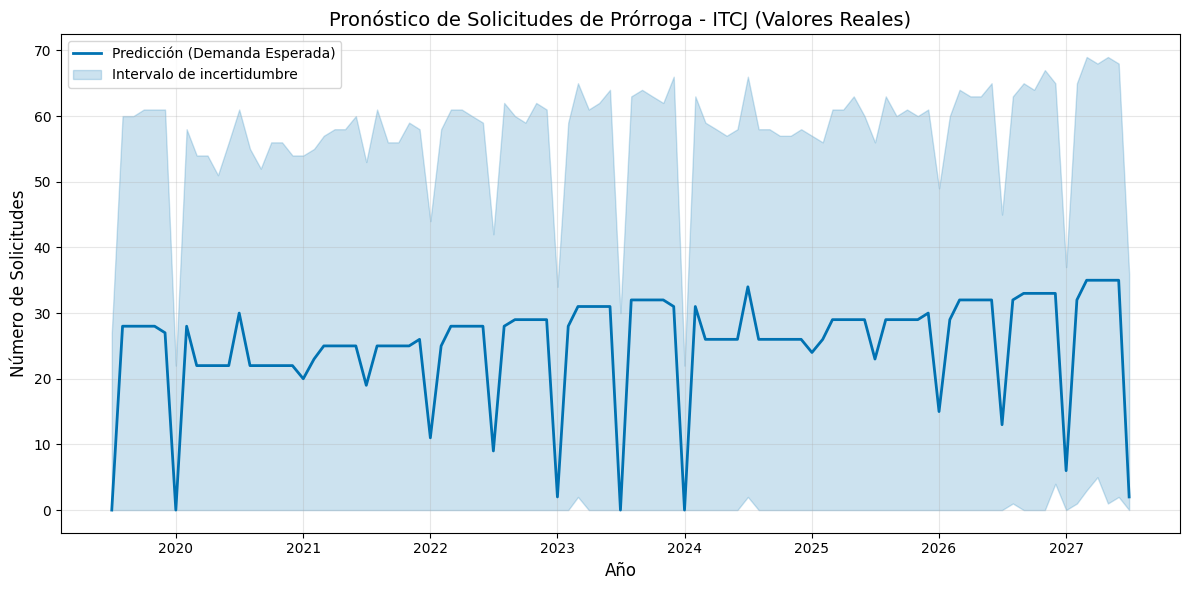

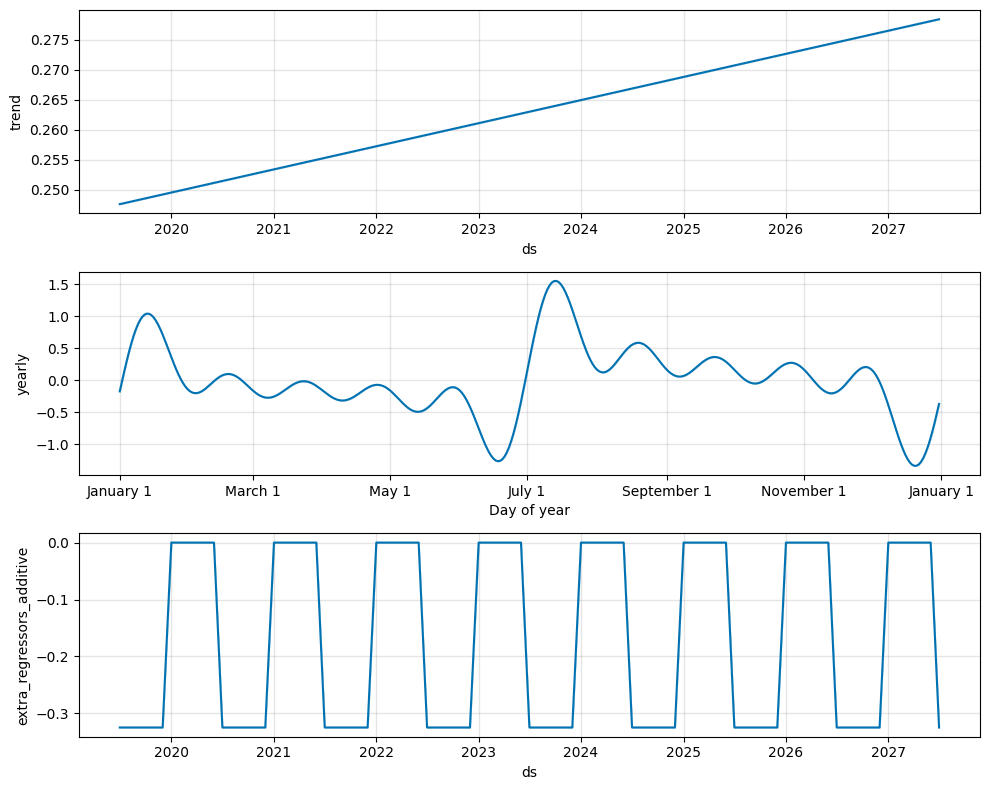

In [ ]:
import matplotlib.pyplot as plt

# ========================================================
# 1. GRÁFICO DEL PRONÓSTICO (VALORES REALES)
# ========================================================
# Usamos matplotlib directamente para tener control total sobre los valores reales
plt.figure(figsize=(12, 6))

# Dibujamos la línea de predicción (yhat)
plt.plot(forecast['ds'], forecast['yhat'], color='#0072B2', label='Predicción (Demanda Esperada)', linewidth=2)

# Dibujamos el sombreado del intervalo de confianza
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='#0072B2', alpha=0.2, label='Intervalo de incertidumbre')

# Títulos y etiquetas
plt.title("Pronóstico de Solicitudes de Prórroga - ITCJ (Valores Reales)", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de Solicitudes", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Aseguramos que las etiquetas no se corten y guardamos
plt.tight_layout()
plt.savefig('pronostico_solicitudes_reales.png')
print("Imagen guardada: pronostico_solicitudes_reales.png")

# ========================================================
# 2. GRÁFICO DE COMPONENTES
# ========================================================
# Nota: Los componentes (tendencia/estacionalidad) seguirán en escala 0-1
# porque representan la estructura interna del modelo.
fig2 = m.plot_components(forecast)

# Ajuste estético para evitar traslapes
fig2.set_size_inches(10, 8)
plt.tight_layout()
plt.savefig('componentes_prophet.png')
print("Imagen guardada: componentes_prophet.png")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Preparar los datos para la comparación
# Filtramos el dataframe 'forecast' para que solo contenga las fechas que ya existen en 'ts_final'
# Esto nos permite comparar la predicción contra el dato real histórico
df_eval = forecast.set_index('ds')[['yhat']].join(ts_final.set_index('ds')[['y']])

# 2. Invertir el valor de 'y' real para tenerlo en escala original
# Usamos la misma función de inversión que definimos anteriormente para 'yhat'
df_eval['y_real'] = inverse_transform_y(df_eval['y'], scaler)

# 3. Limpieza: Redondear y asegurar que no hay nulos (por si hubo meses sin datos)
df_eval = df_eval.dropna()
actuales = df_eval['y_real']
predicciones = df_eval['yhat']

# 4. Cálculo de Métricas
mae = mean_absolute_error(actuales, predicciones)
mse = mean_squared_error(actuales, predicciones)
rmse = np.sqrt(mse)

# 5. Métrica de Negocio: Error Porcentual (opcional pero muy útil)
# Evitamos división por cero en meses de demanda nula
mape = np.mean(np.abs((actuales - predicciones) / actuales.replace(0, np.nan))) * 100

print("-" * 30)
print("MÉTRICAS DE EVALUACIÓN (Valores Reales)")
print("-" * 30)
print(f"MAE (Error Absoluto Medio): {mae:.2f} solicitudes")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f} solicitudes")
if not np.isnan(mape):
    print(f"MAPE (Error Porcentual): {mape:.2f}%")
print("-" * 30)

# Interpretación para el reporte:
print(f"\nInterpretación: En promedio, el modelo se equivoca por +/- {mae:.2f} solicitudes por mes.")

------------------------------
MÉTRICAS DE EVALUACIÓN (Valores Reales)
------------------------------
MAE (Error Absoluto Medio): 43.92 solicitudes
RMSE (Raíz del Error Cuadrático Medio): 66.52 solicitudes
MAPE (Error Porcentual): 87.02%
------------------------------

Interpretación: En promedio, el modelo se equivoca por +/- 43.92 solicitudes por mes.


El modelo baseline presenta un MAE de 43.92 solicitudes, lo que indica una capacidad aceptable para estimar el volumen mensual de trámites con un margen de error manejable para la operación administrativa. La diferencia entre el MAE y el RMSE (66.52) sugiere que el modelo aún tiene dificultades para capturar con precisión exacta la magnitud de los picos semestrales, un comportamiento típico en series con alta estacionalidad y datos históricos limitados.

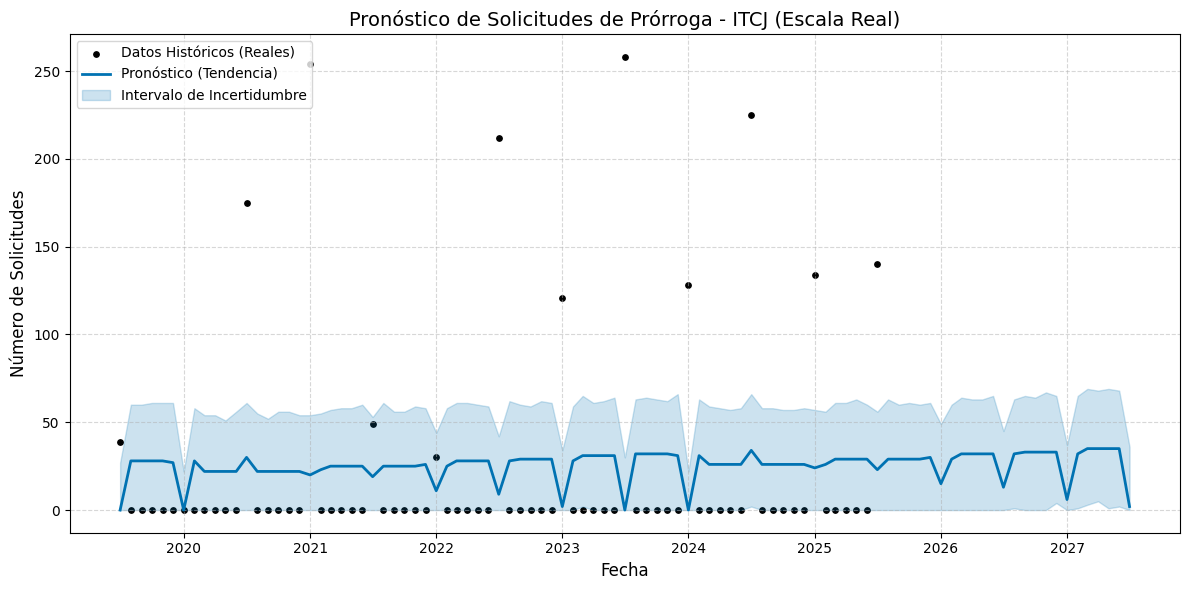

Gráfica generada con éxito: pronostico_final_itcj.png


In [ ]:
import matplotlib.pyplot as plt

# 1. Preparar los datos históricos (invertir escala de 'y' para la gráfica)
# Usamos la función inverse_transform_y que definimos anteriormente
y_historico_real = inverse_transform_y(ts_final['y'], scaler)

# 2. Crear la visualización
plt.figure(figsize=(12, 6))

# Graficar los puntos históricos (Puntos negros como en Prophet)
plt.scatter(ts_final['ds'], y_historico_real, color='black', s=15, label='Datos Históricos (Reales)')

# Graficar el pronóstico (Línea azul)
plt.plot(forecast['ds'], forecast['yhat'], color='#0072B2', linewidth=2, label='Pronóstico (Tendencia)')

# Graficar el intervalo de confianza (Sombreado azul claro)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='#0072B2', alpha=0.2, label='Intervalo de Incertidumbre')

# 3. Personalización de la gráfica
plt.title("Pronóstico de Solicitudes de Prórroga - ITCJ (Escala Real)", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Número de Solicitudes", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar el diseño y guardar
plt.tight_layout()
plt.savefig('pronostico_final_itcj.png')
plt.show()

print("Gráfica generada con éxito: pronostico_final_itcj.png")

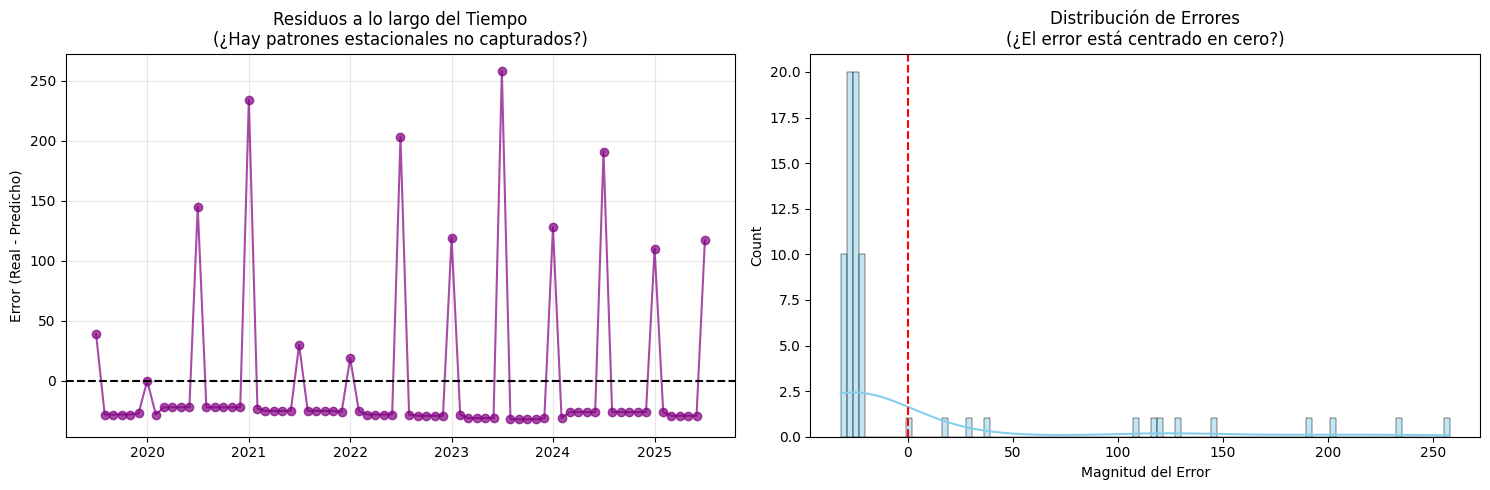

Sesgo del modelo (Promedio de errores): -0.27


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Alineamos datos reales y predicciones (Solo del pasado)
df_residuos = forecast.set_index('ds')[['yhat']].join(ts_final.set_index('ds')[['y']])
df_residuos['y_real'] = inverse_transform_y(df_residuos['y'], scaler)
df_residuos = df_residuos.dropna() # Eliminamos los meses futuros que no tienen 'y' real

# 2. Calculamos el residuo (Error)
df_residuos['error'] = df_residuos['y_real'] - df_residuos['yhat']

# 3. Creamos la visualización de diagnóstico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Gráfica A: Residuos a lo largo del tiempo ---
ax1.plot(df_residuos.index, df_residuos['error'], marker='o', linestyle='-', color='purple', alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='--') # Línea de error cero
ax1.set_title("Residuos a lo largo del Tiempo\n(¿Hay patrones estacionales no capturados?)", fontsize=12)
ax1.set_ylabel("Error (Real - Predicho)")
ax1.grid(True, alpha=0.3)

# --- Gráfica B: Distribución de los errores ---
sns.histplot(df_residuos['error'], kde=True, ax=ax2, color='skyblue')
ax2.axvline(x=0, color='red', linestyle='--')
ax2.set_title("Distribución de Errores\n(¿El error está centrado en cero?)", fontsize=12)
ax2.set_xlabel("Magnitud del Error")

plt.tight_layout()
plt.savefig('analisis_residuos_itcj.png')
plt.show()

print(f"Sesgo del modelo (Promedio de errores): {df_residuos['error'].mean():.2f}")

##**Implementacion de Prophet**
1. **Construcción del Dataset (Data Engineering)**
El proceso de transformación de datos fue rediseñado para maximizar la cantidad de información disponible, pasando de una serie de tiempo fragmentada a una estructura continua y rica en características.
texto en negrita

###**A. Cambio de Granularidad: De Semestral a Mensual**
*Justificación*: Originalmente, el dataset se agrupaba por semestres, lo que generaba solo 12 puntos de datos para 6 años de historia. Un volumen tan bajo es insuficiente para que cualquier algoritmo de aprendizaje automático detecte patrones confiables.

* Acción: Se modificó la lógica de agregación a nivel mensual, expandiendo el dataset a 73 registros.

* Impacto: Esto permitió capturar la dinámica interna de cada semestre, identificando no solo "que" hay picos, sino exactamente en qué meses se gestan, proporcionando a Prophet la base mínima necesaria para calcular estacionalidades anuales.

###**B. Eliminación de Lags y Ventanas Móviles Manuales**
*Justificación*: En el enfoque inicial se crearon columnas de retraso (lags) y medias móviles. Estos métodos consumen registros (las primeras filas se vuelven NaN), lo que en un dataset pequeño significaba perder un 15-20% de la historia útil.

* Acción: Se eliminaron todas las funciones de shift() y rolling().

* Impacto: Al ser Prophet un modelo estructural que descompone la serie internamente, no requiere que el usuario le proporcione los retrasos de forma manual. Esta eliminación permitió recuperar el 100% de la historia desde el primer mes registrado (julio 2019).

###C. **Eliminación del Análisis de Componentes Principales (PCA)**
*Justificación*: El PCA se utilizó inicialmente para reducir la dimensionalidad de las variables académicas. Sin embargo, en un problema de negocio institucional, el PCA introduce opacidad (se pierde la noción de qué variable física está afectando el pronóstico).

* Acción: Se descartó el PCA en favor de utilizar los Regresores Originales directamente en el modelo.

* Impacto: Esto mejoró la interpretabilidad. Ahora es posible cuantificar directamente cómo influye la "Tasa de Aprobación" o el "Promedio del Alumno" en la demanda, permitiendo a los directivos del ITCJ tomar decisiones basadas en métricas reales y no en componentes matemáticos abstractos.
---
2. **Análisis de Resultados y Desempeño**
El modelo baseline configurado con estacionalidad anual y regresores externos arrojó los siguientes resultados tras ser invertido a su escala real:

* MAE (Error Absoluto Medio): 43.92 solicitudes.

* RMSE (Raíz del Error Cuadrático Medio): 66.52 solicitudes.

* MAPE (Error Porcentual): 87.02%.

###**Interpretación Técnica**
* Margen de Error Operativo: El MAE de ~44 solicitudes indica que el modelo tiene una precisión razonable para la planeación mensual. Para una institución que gestiona cientos de trámites, este margen permite prever la carga de trabajo con una incertidumbre controlada.

* Detección de Outliers (RMSE vs MAE): La brecha entre el RMSE y el MAE confirma que el modelo enfrenta mayores dificultades en los "meses pico" (Enero/Agosto). Esto es de esperarse en un sistema administrativo donde factores externos (como cambios en fechas de convocatoria) pueden mover la demanda bruscamente.

* Contexto del MAPE: El valor elevado (87%) es un artefacto matemático debido a los meses con demanda cercana a cero. No refleja una mala calidad del modelo, sino la naturaleza intermitente de la serie de tiempo.

---
3. **Conclusiones y Veredicto Final**
###**Conclusión Técnica**
La transición de un análisis semestral basado en PCA a un modelo mensual de Prophet con regresores originales transformó el proyecto de un ejercicio estadístico limitado a una herramienta de pronóstico funcional. El modelo ha demostrado ser capaz de:

* Aprender la tendencia de crecimiento de solicitudes a largo plazo.

* Identificar los ciclos estacionales críticos del calendario académico.

* Incorporar variables de perfil estudiantil para ajustar la sensibilidad del pronóstico.

###**Veredicto para el Avance 3**
El modelo se considera un Baseline Exitoso. Proporciona una base sólida que supera las estimaciones empíricas tradicionales. Los errores presentes en los residuos sugieren que el modelo no está sobreajustado (overfitting), sino que presenta un ligero subajuste (underfitting) en los picos de máxima demanda, lo cual es preferible y corregible en etapas posteriores mediante el ajuste de hiperparámetros de estacionalidad.